# Test ConstantPopVitalDynamics

Let's set up an endemic infection scenario with constant population.

In [1]:
import numba as nb
import numpy as np
import matplotlib.pyplot as plt



In [2]:
import laser.core.distributions as dists
from laser.core import PropertySet
from laser.core.utils import grid
from laser.generic.newutils import ValuesMap
from laser.generic import Model
from laser.generic import SEIR
from laser.generic.vitaldynamics import ConstantPopVitalDynamics
from laser.generic import State


In [3]:
NTICKS = 10 * 365
R0 = 10  # measles-ish
EXPOSED_DURATION_MEAN = 4.5
EXPOSED_DURATION_SCALE = 1.0
INFECTIOUS_DURATION_MEAN = 7.0
INFECTIOUS_DURATION_SCALE = 2.0

scenario = grid(M=5, N=5, population_fn=lambda x, y: int(np.random.uniform(10_000, 1_000_000)))
init_susceptible = np.round(scenario.population / R0).astype(np.int32)  # 1/R0 already recovered
equilibrium_prevalence = 9000 / 12_000_000
init_infected = np.round(equilibrium_prevalence * scenario.population).astype(np.int32)
scenario["S"] = init_susceptible
scenario["E"] = 0
scenario["I"] = init_infected
scenario["R"] = scenario.population - init_susceptible - init_infected

params = PropertySet({"nticks": NTICKS, "beta": R0 / INFECTIOUS_DURATION_MEAN})
birthrates_map = ValuesMap.from_scalar(35, nsteps=NTICKS, nnodes=len(scenario))

model = Model(scenario, params, birthrates=birthrates_map)
# model.validating = True

expdist = dists.normal(loc=EXPOSED_DURATION_MEAN, scale=EXPOSED_DURATION_SCALE)
infdist = dists.normal(loc=INFECTIOUS_DURATION_MEAN, scale=INFECTIOUS_DURATION_SCALE)

s = SEIR.Susceptible(model)
e = SEIR.Exposed(model, expdist, infdist)
i = SEIR.Infectious(model, infdist)
r = SEIR.Recovered(model)
tx = SEIR.Transmission(model, expdist)

vitals = ConstantPopVitalDynamics(
    model,
    recycle_rates=birthrates_map,
)

model.components = [s, r, i, e, tx, vitals]

label = f"SEIR with ({model.people.count:,} agents in {model.nodes.count:,} nodes)"
model.run(label)


SEIR with (13,405,609 agents in 25 nodes): 100%|██████████| 3650/3650 [00:24<00:00, 147.76it/s]


## Recycling Over Time


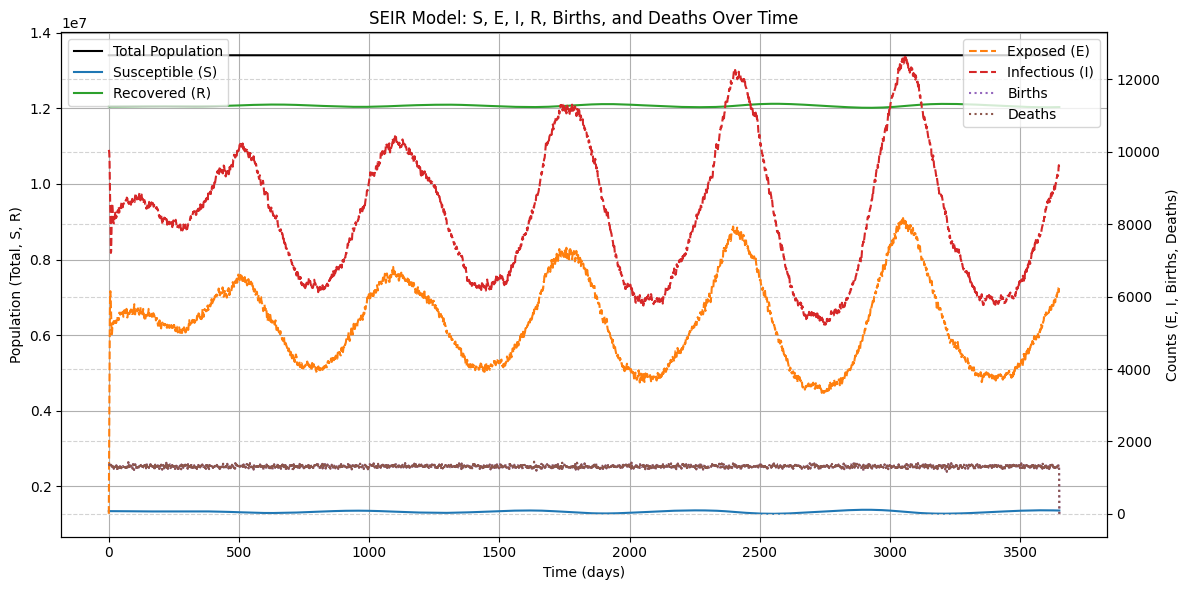

In [4]:
fig, ax1 = plt.subplots(figsize=(12, 6))

total_pop = model.nodes.S + model.nodes.E + model.nodes.I + model.nodes.R

# Primary axis: S and R
ax1.plot(total_pop.sum(axis=1), label="Total Population", color="black")
ax1.plot(model.nodes.S.sum(axis=1), label="Susceptible (S)", color="tab:blue")
ax1.plot(model.nodes.R.sum(axis=1), label="Recovered (R)", color="tab:green")
ax1.set_xlabel("Time (days)")
ax1.set_ylabel("Population (Total, S, R)")
ax1.legend(loc="upper left")

# Secondary axis: E, I, births, deaths
ax2 = ax1.twinx()
ax2.plot(model.nodes.E.sum(axis=1), label="Exposed (E)", color="tab:orange", linestyle="--")
ax2.plot(model.nodes.I.sum(axis=1), label="Infectious (I)", color="tab:red", linestyle="--")
ax2.plot(model.nodes.births.sum(axis=1), label="Births", color="tab:purple", linestyle=":")
ax2.plot(model.nodes.deaths.sum(axis=1), label="Deaths", color="tab:brown", linestyle=":")

ax2.set_ylabel("Counts (E, I, Births, Deaths)")
ax2.legend(loc="upper right")

plt.title("SEIR Model: S, E, I, R, Births, and Deaths Over Time")
ax1.grid()
ax2.grid(color="lightgray", linestyle="--")
plt.tight_layout()
plt.show()